In [1]:
from data_processing import Dataset
import matplotlib.pyplot as plt
import numpy as np
from noise import NoiseScheduler
import tensorflow as tf
from jet_finding import *
from tqdm.notebook import tqdm
import random

seed = 22
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the device to custom GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[0] # Specify which gpu to use here. Can run multiple scripts on different GPUs
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
        print("CUDA is available!")
        print("Number of available GPUs:", len(gpus))
        print("Current GPU:", gpu)
    except RuntimeError as e:
        print(e)
else:
    print("CUDA is not available. Running on CPU.")

2024-07-29 13:11:27.327783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 13:11:27.367595: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CUDA is available!
Number of available GPUs: 1
Current GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-07-29 13:11:28.658381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:11:28.671475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:11:28.671504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Set to directory where data is stored
work_home = False
data_dir = "Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(end_idx-start_idx, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx) # 120 eta, 72 phi

In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:Loading .npy files from /home/themrluke/projects/stablediffusion/keras_version/signal.npy and /home/themrluke/projects/stablediffusion/keras_version/pile_up.npy


In [4]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(new_dim)     # ensure these have the same values as when the model was trained

INFO:root:Re-sizing tensors...


In [5]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

if strip_size == 'full_image':
    y_start = 0
    y_end = 64

elif strip_size == 'strip':
    y_start = 26
    y_end = 38

In [6]:
# Convert data to TensorFlow tensors
clean_frames = tf.convert_to_tensor(dataset.signal, dtype=tf.float32)[:, y_start:y_end, :]
pile_up = tf.convert_to_tensor(dataset.pile_up, dtype=tf.float32)[:, y_start:y_end, :]

# Normalize data
clean_frames = tf.clip_by_value(clean_frames, 0, saturation_value)
pile_up = tf.clip_by_value(pile_up, 0, saturation_value)

# Reshape data
clean_frames = tf.expand_dims(clean_frames, axis=-1)
pile_up = tf.expand_dims(pile_up, axis=-1)

print(clean_frames.shape)

(300, 64, 64, 1)


2024-07-29 13:11:29.258702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 13:11:29.260189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:11:29.260218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:11:29.260231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/de

In [7]:
testEvent=10

# Create noise scheduler
noise_scheduler = NoiseScheduler('pile-up')

# Each unit of timestep represents an additional 5 pile-up events (max 40 = 200PU)
timestep = tf.convert_to_tensor(40)

random_seed = np.random.randint(0, end_idx-start_idx)
noisy_image, noise = noise_scheduler.add_noise(clean_frame=tf.expand_dims(clean_frames[testEvent], 0), noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
# Apply saturation value clipping
noisy_image = tf.clip_by_value(noisy_image, 0, saturation_value)


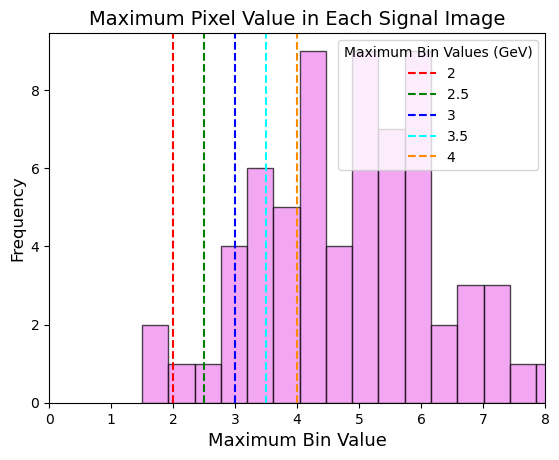

Threshold (GeV)      Perc of Events Above Threshold(%)
0.5                  100.00                   
1                    100.00                   
1.5                  99.67                    
2                    99.00                    
2.5                  98.67                    
3                    98.00                    
3.5                  95.67                    
4                    94.00                    
4.5                  90.67                    
5                    87.67                    


In [8]:
# Aside: calculate the maximum pixel value in each event loaded in the Dataset
max_bin = np.zeros(end_idx-start_idx)
for event in range(end_idx-start_idx):
    max_bin[event] = tf.reduce_max(clean_frames[event])

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(max_bin, bins=1000, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Signal Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
thresholds = [2, 2.5, 3, 3.5, 4, 4.5, 5]
# Plot vertical lines at threshold values
plt.axvline(x=thresholds[0], color='r', linestyle='--', label=thresholds[0])
plt.axvline(x=thresholds[1], color='green', linestyle='--', label=thresholds[1])
plt.axvline(x=thresholds[2], color='blue', linestyle='--', label=thresholds[2])
plt.axvline(x=thresholds[3], color='cyan', linestyle='--', label=thresholds[3])
plt.axvline(x=thresholds[4], color='darkorange', linestyle='--', label=thresholds[4])
plt.xlim(0,8)

# Add legend
plt.legend(title='Maximum Bin Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
percentages = [(max_bin > threshold).sum() / len(max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

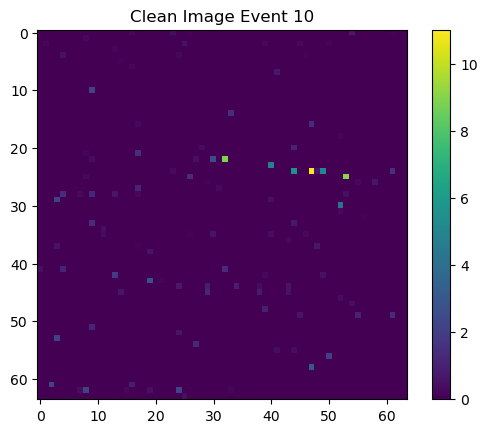

In [9]:
plt.imshow(clean_frames[testEvent])
plt.colorbar()
plt.title(f"Clean Image Event {testEvent}")
plt.show()

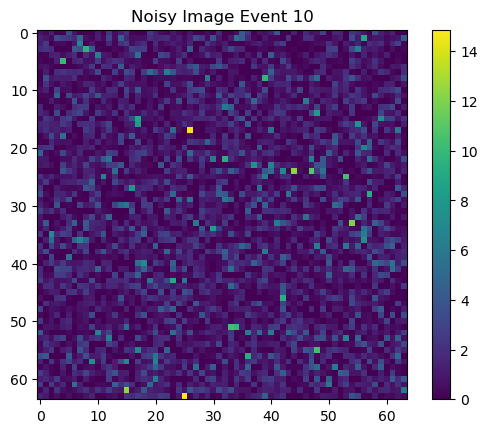

In [10]:
plt.imshow(noisy_image[0])
plt.colorbar()
plt.title(f"Noisy Image Event {testEvent}")
plt.show()

In [11]:
from Models.models_reduced_constkernels import Model #see models.py file

modtype = 'UNet_lite' # Change Model type here
model = Model(modtype, new_dim)
model = model.__getitem__()

if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model
    #trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    trained_model_path = 'retrained_models_UNet2d/saturation=512/model_epoch_9.pt'

elif modtype == 'UNet_lite':
    trained_model_path = 'trained_models_lite/reduced_constkernels/model_epoch_9.h5' # Specify folder for which trained model here!

print('Trained Model Path: ', trained_model_path)
dummy_input = tf.zeros((1, new_dim[0], new_dim[1], 1), dtype=tf.float32)
dummy_time = tf.zeros((), dtype=tf.int32)
model((dummy_input, dummy_time))
print('Number of learnable params: ', model.count_params())

model.load_weights(trained_model_path)
print(model.summary()) # PRINT MODEL

Trained Model Path:  trained_models_lite/reduced_constkernels/model_epoch_9.h5


2024-07-29 13:11:30.775146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-29 13:11:30.792809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-07-29 13:11:30.845096: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


Number of learnable params:  4950
Model: "u_net_lite_hls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding (Positi  multiple                 0         
 onalEncoding)                                                   
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 dense (Dense)               multiple                  5         
                                                                 
 conv2d (Conv2D)             multiple                  72        
                                                                 
 layer_normalization (LayerN  multiple                 16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)

In [12]:
if modtype == 'UNet2d':
    noise_pred = model([noisy_image, timestep], training=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model([noisy_image, timestep], training=False)

In [13]:
de_noised = tf.nn.relu(noisy_image - noise_pred)

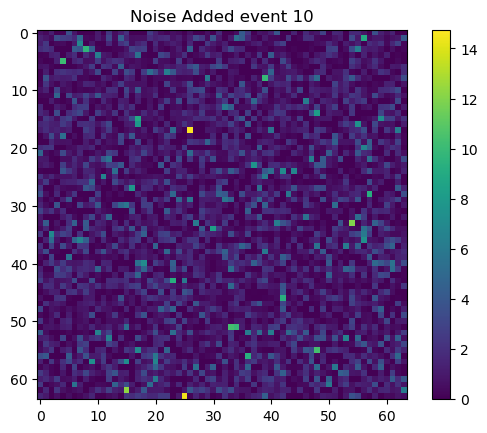

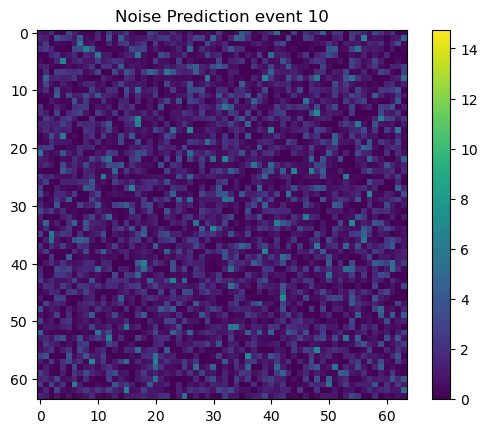

In [14]:
# Calculate the min and max values for setting the color scale
vmin = min(noise_pred.numpy().min(), noise.numpy().min())
vmax = max(noise_pred.numpy().max(), noise.numpy().max())

# Display the noise added
ims2 = plt.imshow(noise[0])
plt.colorbar(ims2)
plt.title(f"Noise Added event {testEvent}")
plt.show()

# Display the noise prediction
ims = plt.imshow(noise_pred[0], vmin=vmin, vmax=vmax) # Move prediction back to CPU for visualization
plt.colorbar(ims)
plt.title(f"Noise Prediction event {testEvent}")
plt.show()

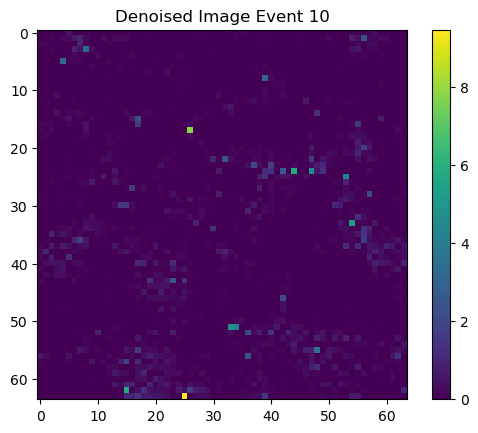

In [15]:
im = plt.imshow(de_noised[0])
plt.colorbar(im)
plt.title(f"Denoised Image Event {testEvent}")
plt.show()

In [16]:
local_maxima, jets_clean = find_local_maxima(tf.expand_dims(clean_frames[testEvent], 0), 9)
print(local_maxima)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]


Number of local maxima:  3


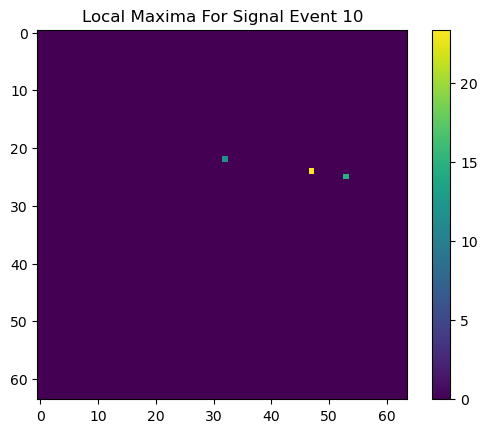

In [17]:

plt.imshow(local_maxima[0])
print('Number of local maxima: ', len(jets_clean))
plt.colorbar()
plt.title(f"Local Maxima For Signal Event {testEvent}")
plt.show()

Number of local maxima:  16


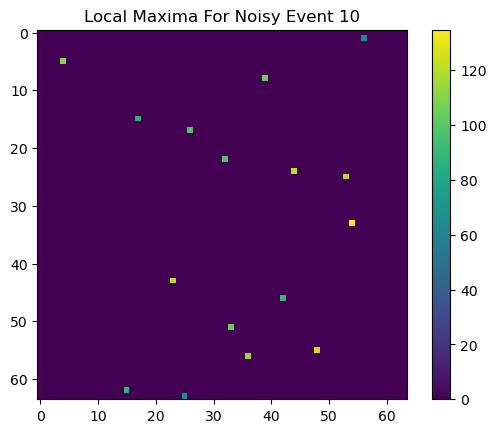

In [18]:
local_maxima, jets_noisy = find_local_maxima(noisy_image, 9)
print ('Number of local maxima: ', len(jets_noisy))
plt.imshow(local_maxima[0])
plt.colorbar()
plt.title(f"Local Maxima For Noisy Event {testEvent}")
plt.show()

Number of local maxima:  6


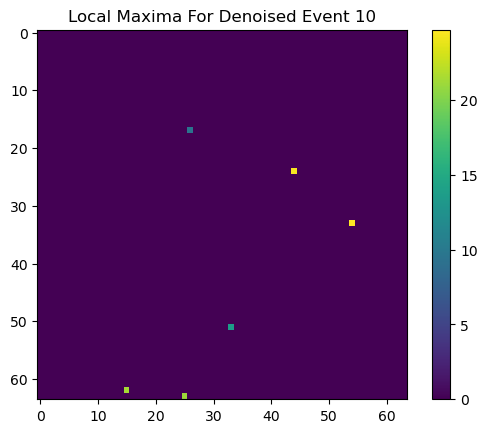

In [19]:
local_maxima, jets_denoised = find_local_maxima(de_noised, 9)
print ('Number of local maxima: ', len(jets_denoised))
plt.imshow(local_maxima[0])
plt.colorbar()
plt.title(f"Local Maxima For Denoised Event {testEvent}")
plt.show()

In [20]:
print (jets_denoised)

[{'event': 0, 'i': 17, 'j': 26, 'pixel_value': 7.7882967, 'sum_around_maxima': 9.533976}, {'event': 0, 'i': 24, 'j': 44, 'pixel_value': 5.816656, 'sum_around_maxima': 24.479395}, {'event': 0, 'i': 33, 'j': 54, 'pixel_value': 5.0986376, 'sum_around_maxima': 24.692425}, {'event': 0, 'i': 51, 'j': 33, 'pixel_value': 4.7855883, 'sum_around_maxima': 13.645574}, {'event': 0, 'i': 62, 'j': 15, 'pixel_value': 5.8635254, 'sum_around_maxima': 21.40195}, {'event': 0, 'i': 63, 'j': 25, 'pixel_value': 9.473962, 'sum_around_maxima': 21.089064}]


Reference Maxima: {'event': 0, 'i': 22, 'j': 32, 'pixel_value': 8.925471, 'sum_around_maxima': 12.013487}, Test Maxima: {'event': 0, 'i': 22, 'j': 32, 'pixel_value': 9.337452, 'sum_around_maxima': 98.361984}
Reference Maxima: {'event': 0, 'i': 25, 'j': 53, 'pixel_value': 9.065568, 'sum_around_maxima': 14.822347}, Test Maxima: {'event': 0, 'i': 25, 'j': 53, 'pixel_value': 10.35251, 'sum_around_maxima': 118.612366}


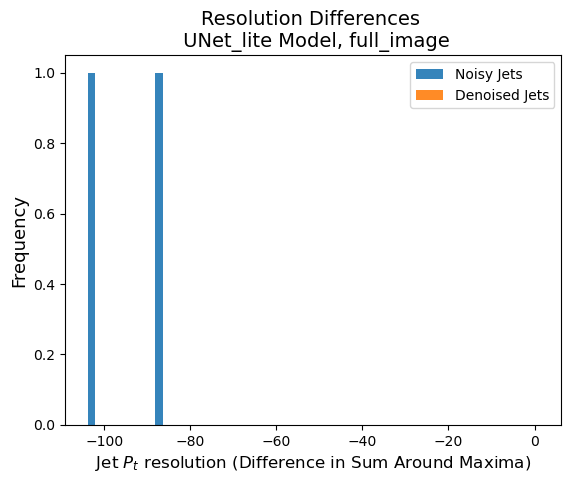

In [21]:
differences_allJetTypes = []
for test_jets in [jets_noisy, jets_denoised]:
    matching_jets = find_matching_maxima(jets_clean, test_jets)
    
    for ref_maxima, test_maxima_entry in matching_jets:
        print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

    differences = [ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                   for ref_maxima, test_maxima_entry in matching_jets]
    differences_allJetTypes.append(differences)

# Plot histograms for each set of differences
for differences, label in zip(differences_allJetTypes, ['Noisy Jets', 'Denoised Jets']):
        plt.hist(differences, alpha=0.9, label=label)

plt.title(f'Resolution Differences \n {modtype} Model, {strip_size}', fontsize=14)
plt.xlabel('Jet $P_t$ resolution (Difference in Sum Around Maxima)', fontsize=12)
plt.ylabel('Frequency', fontsize=13)
plt.legend()
plt.show()

Local Maxima Finding:   0%|          | 0/3 [00:00<?, ?it/s]

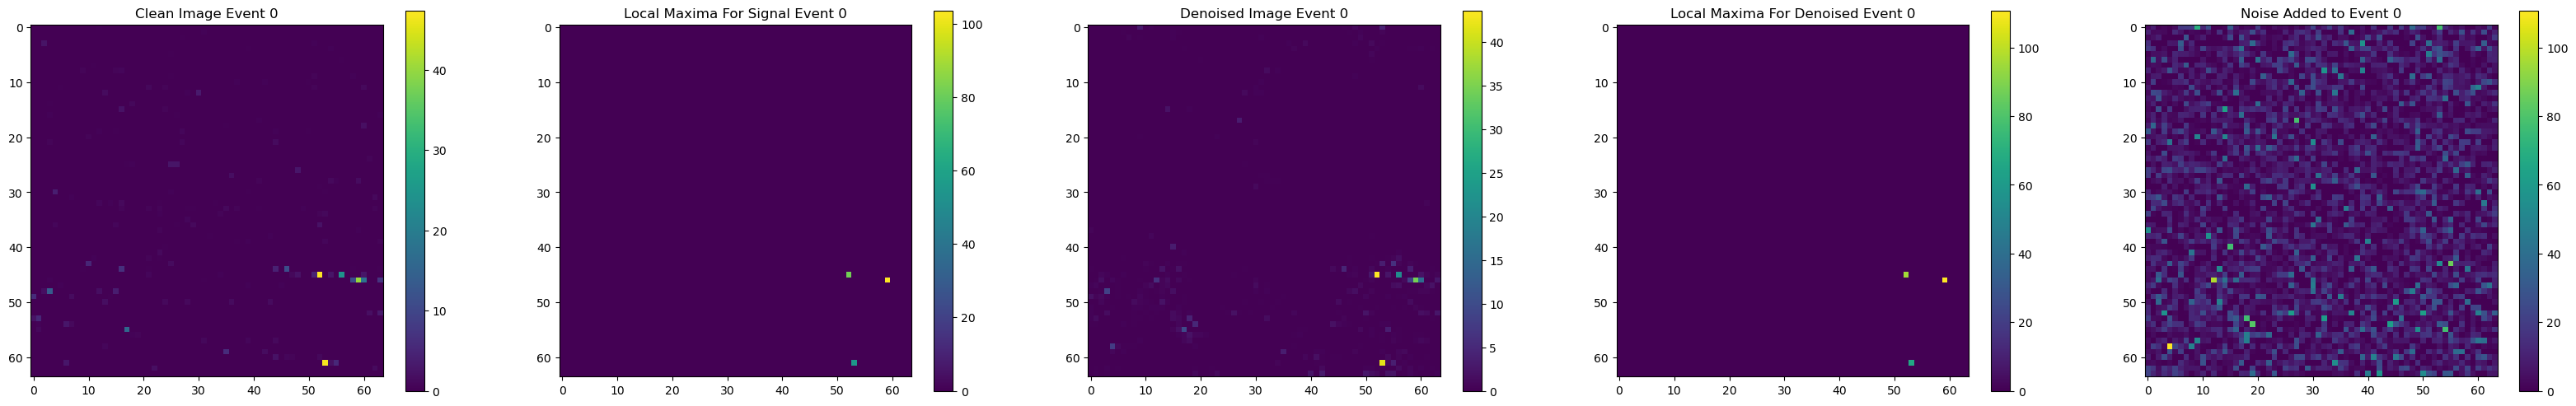

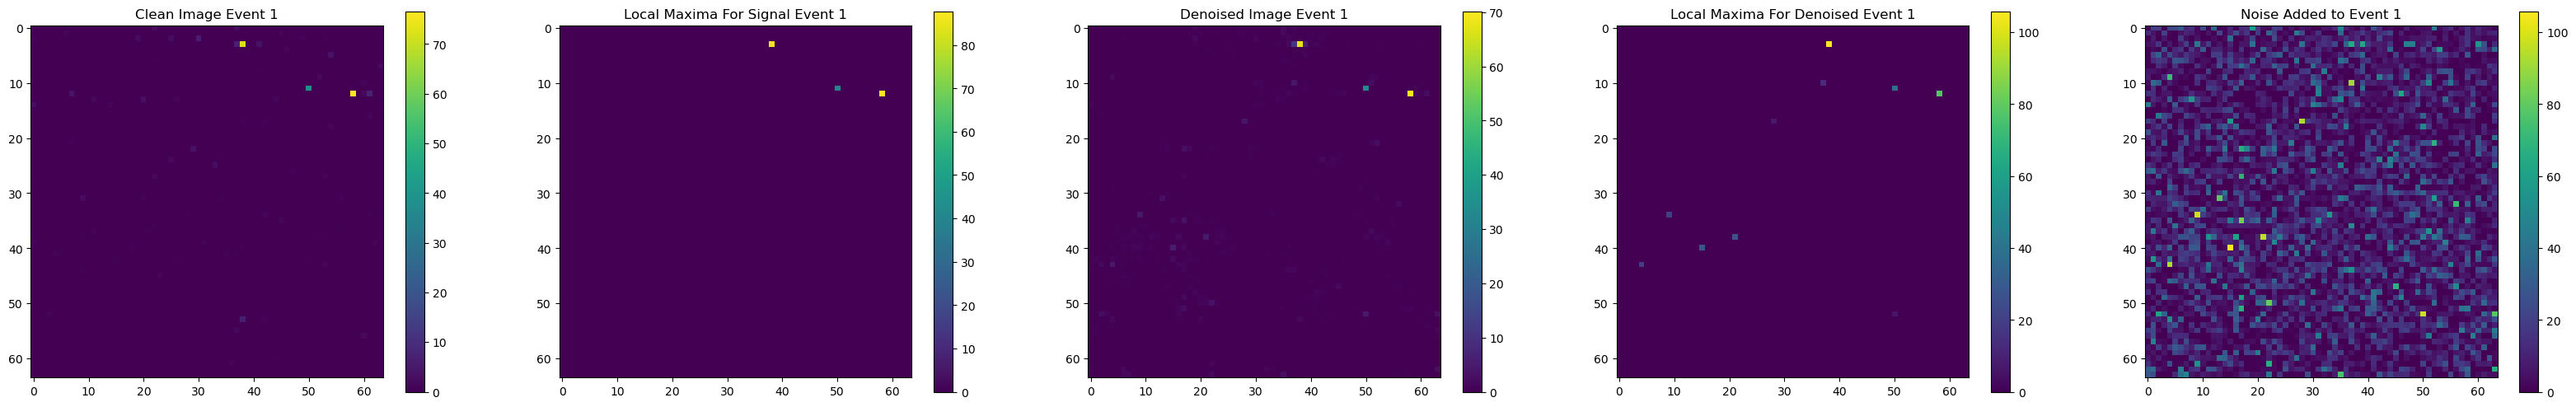

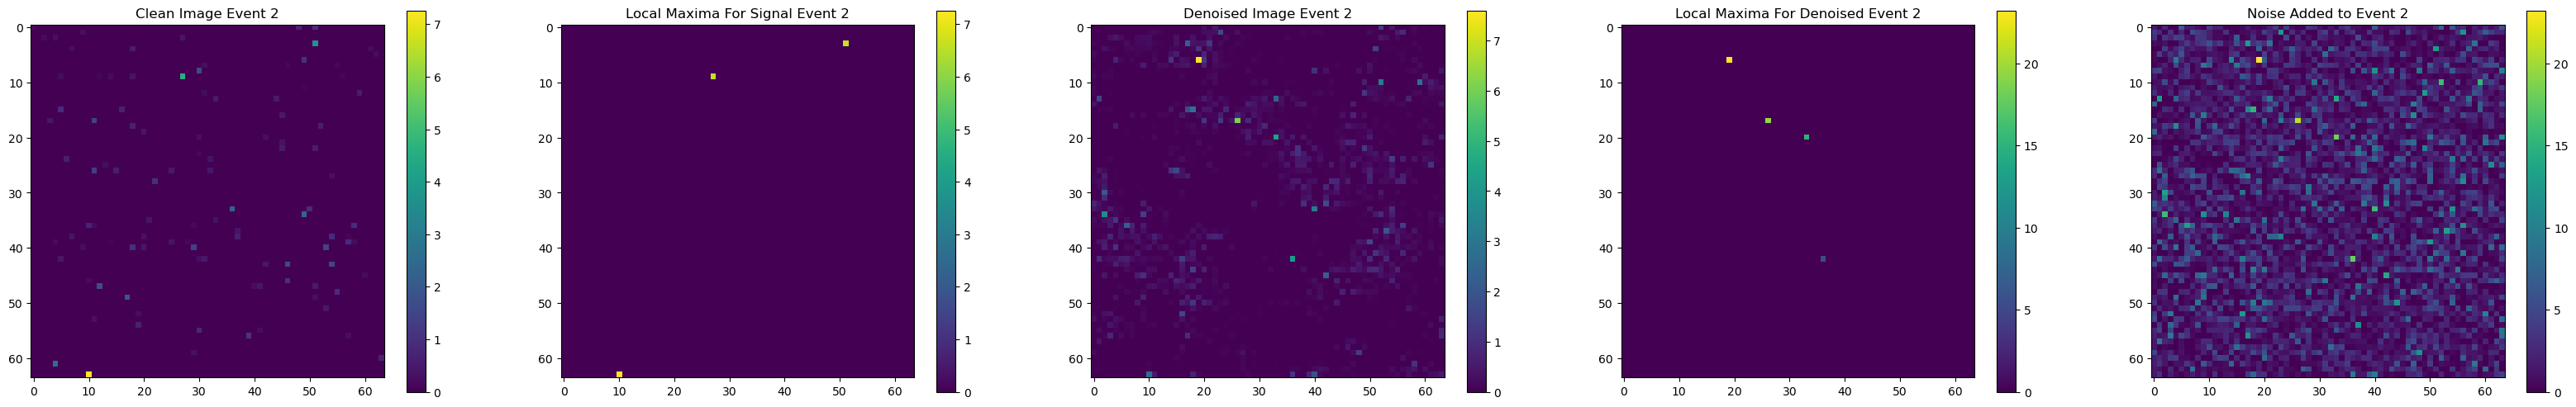

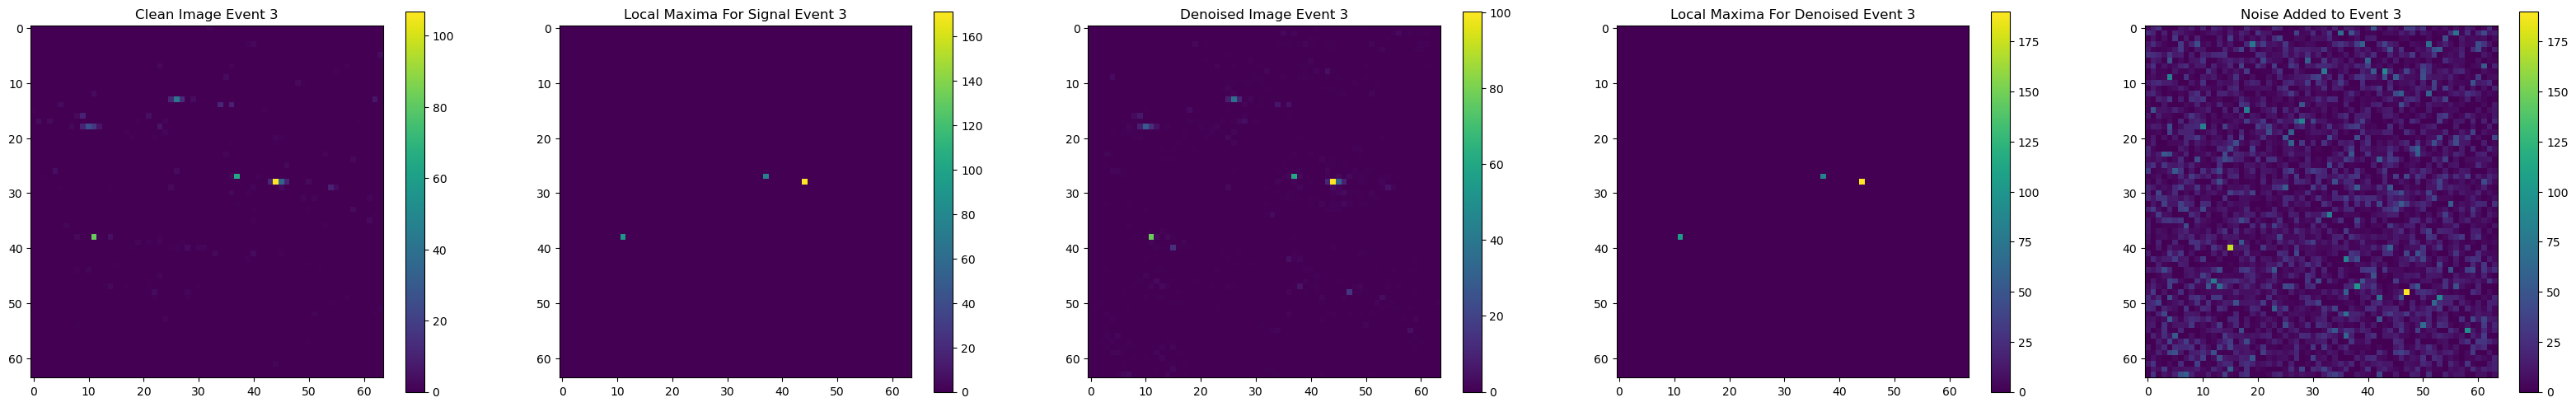

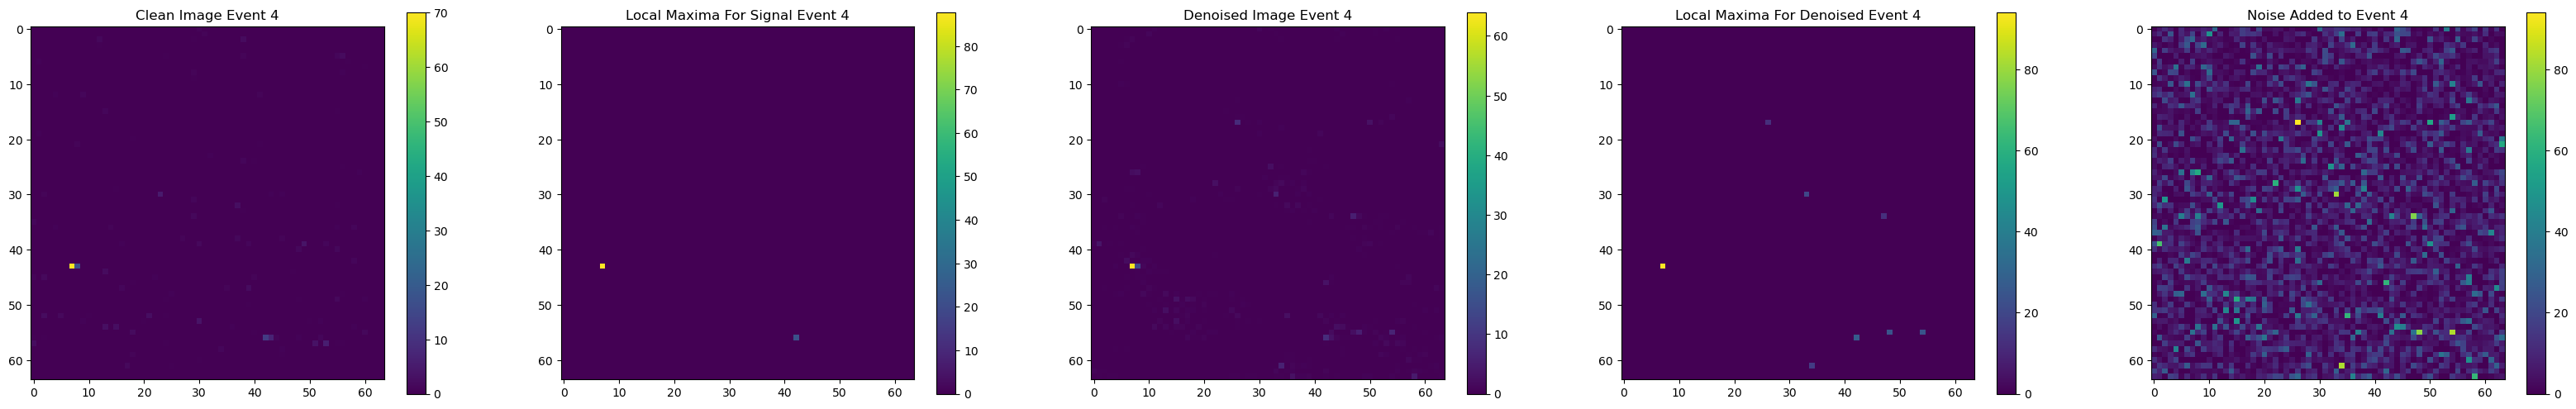

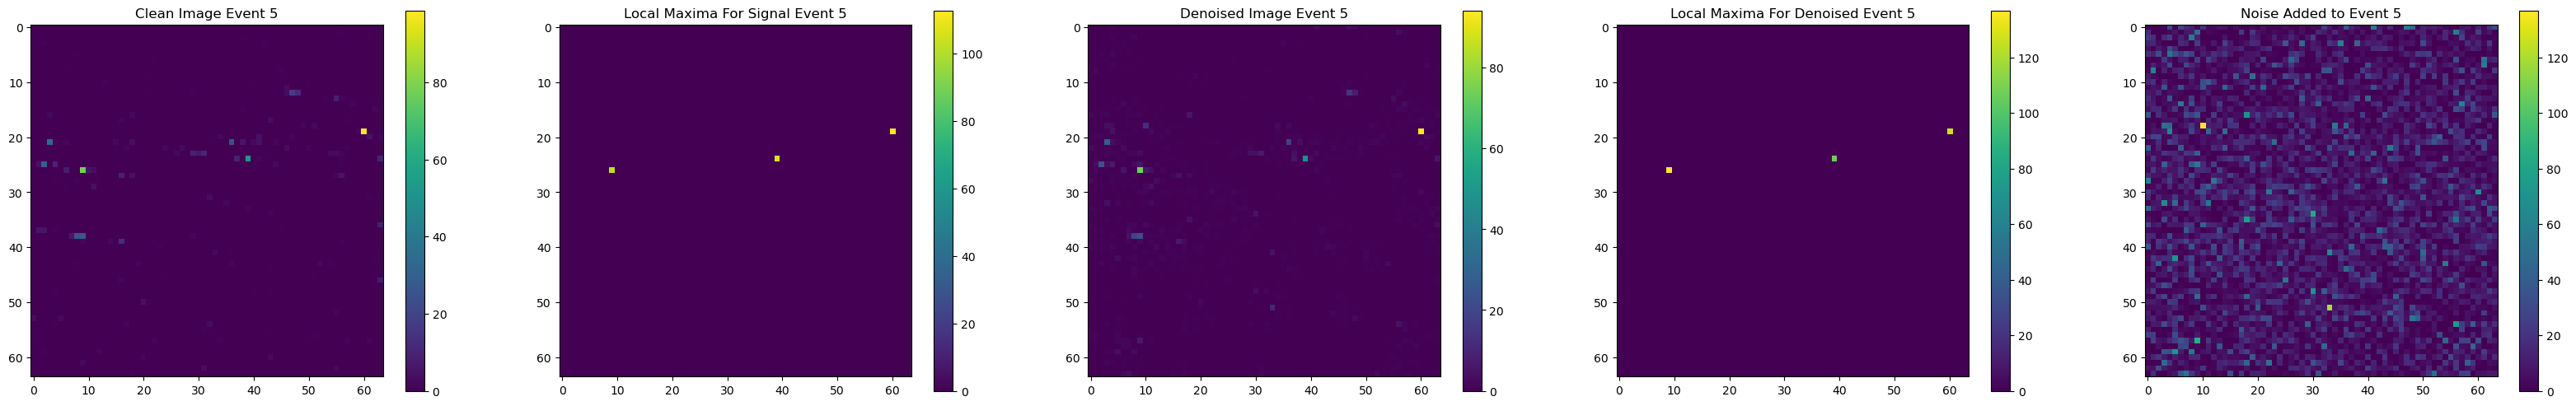

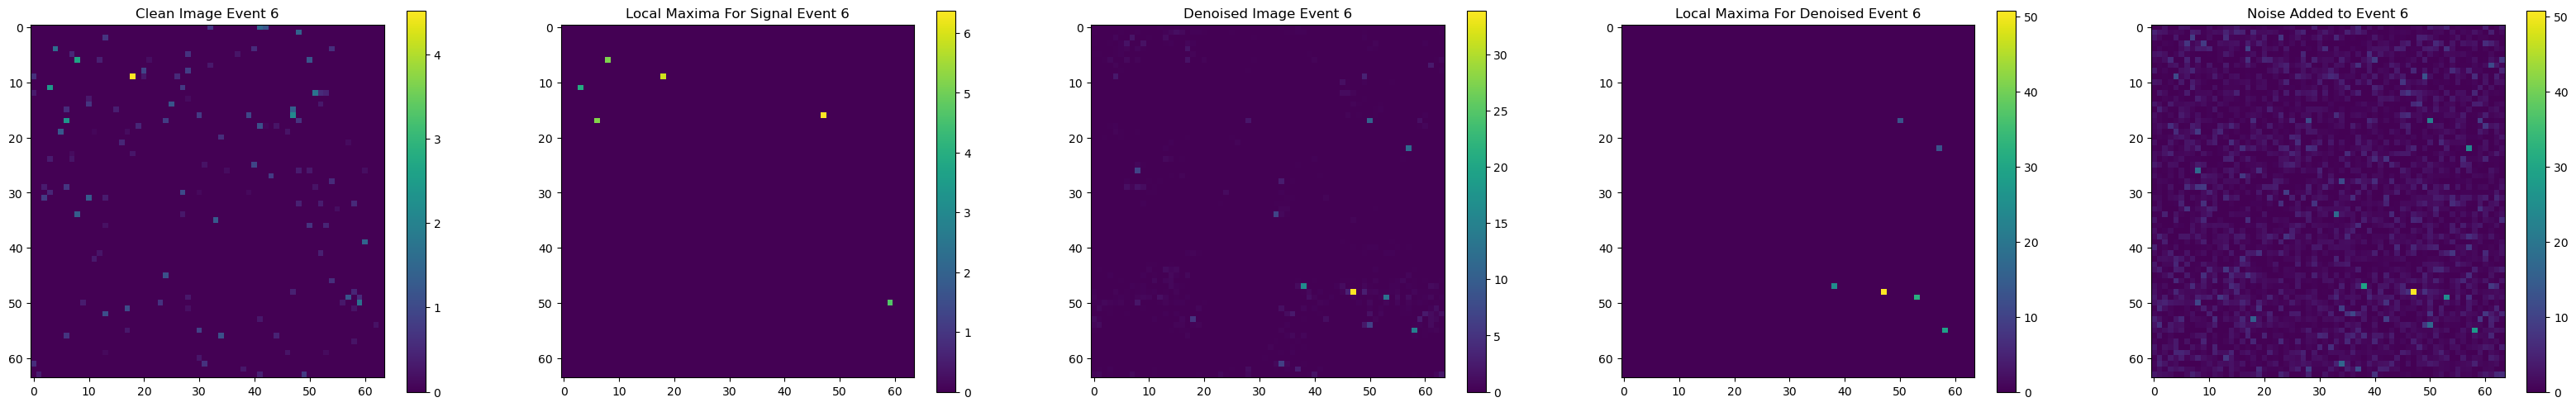

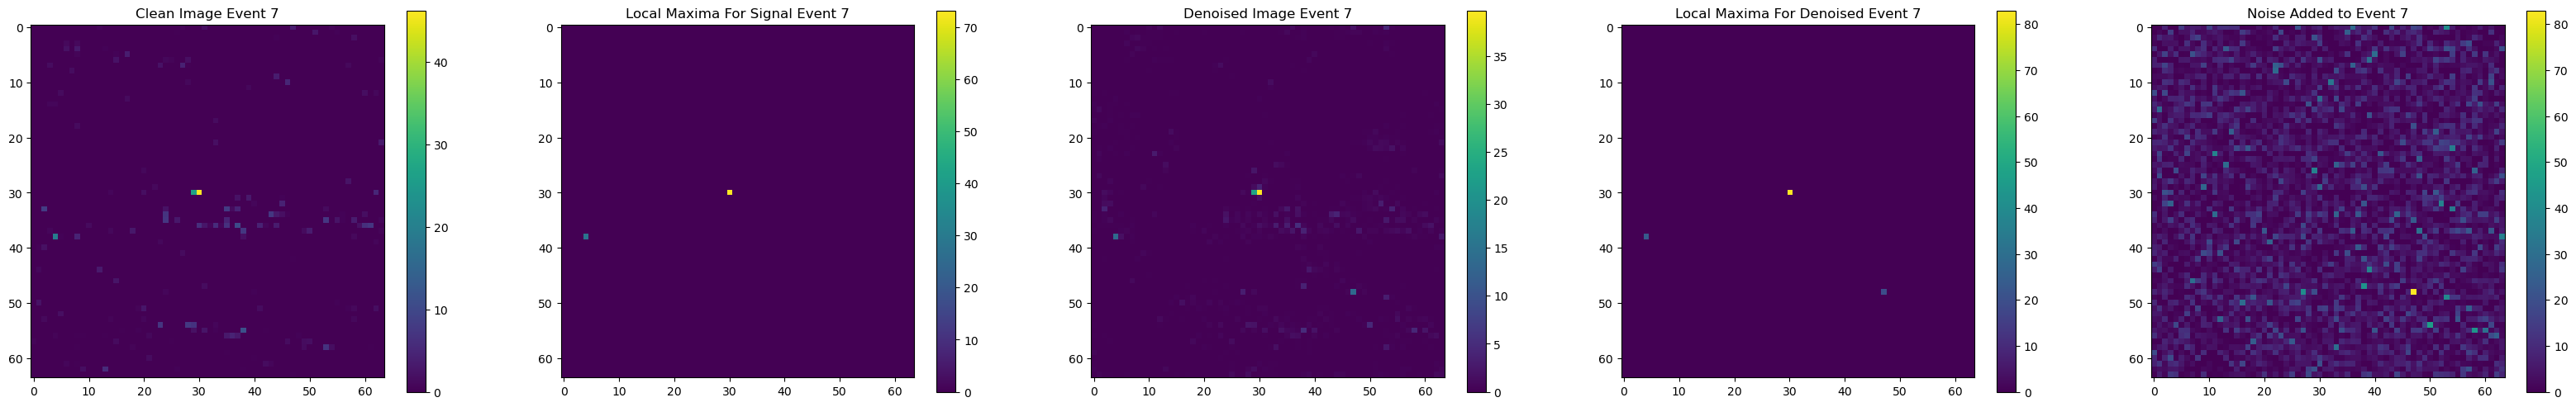

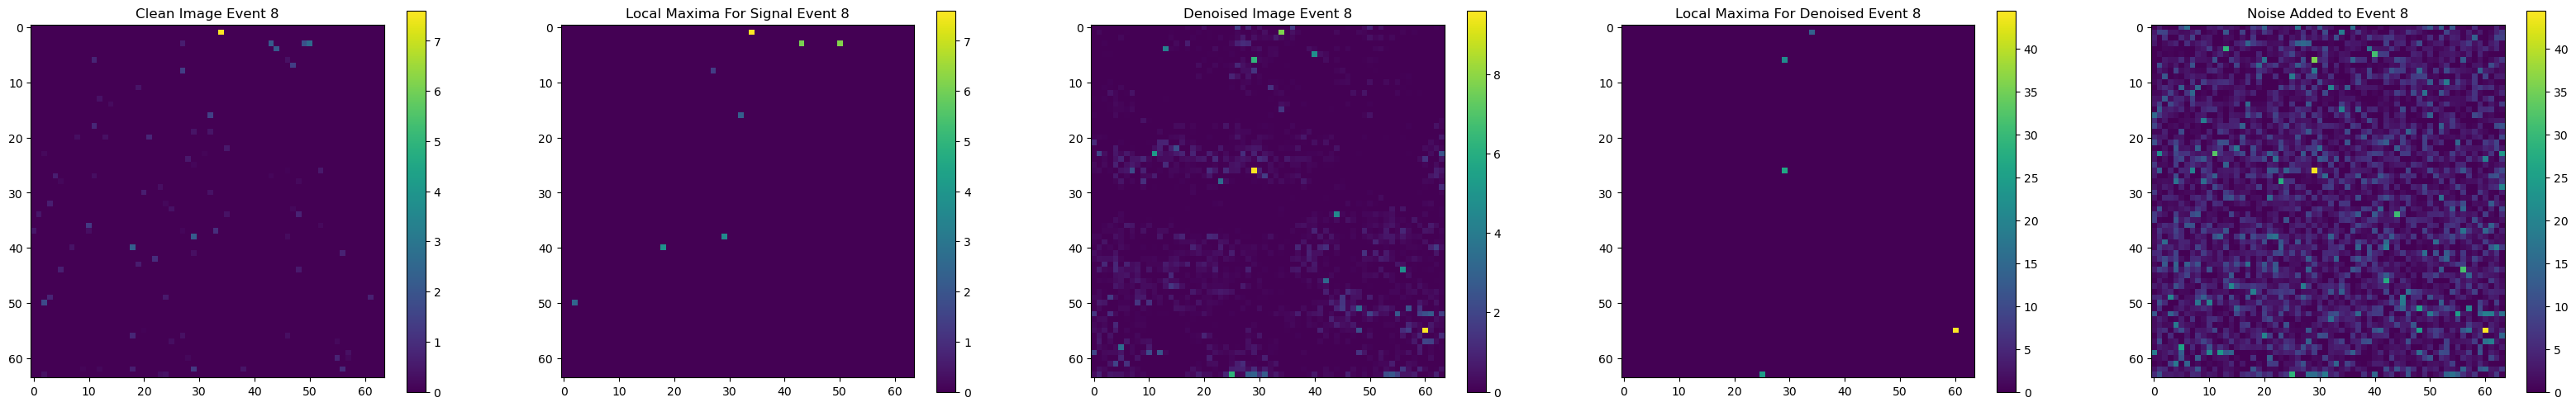

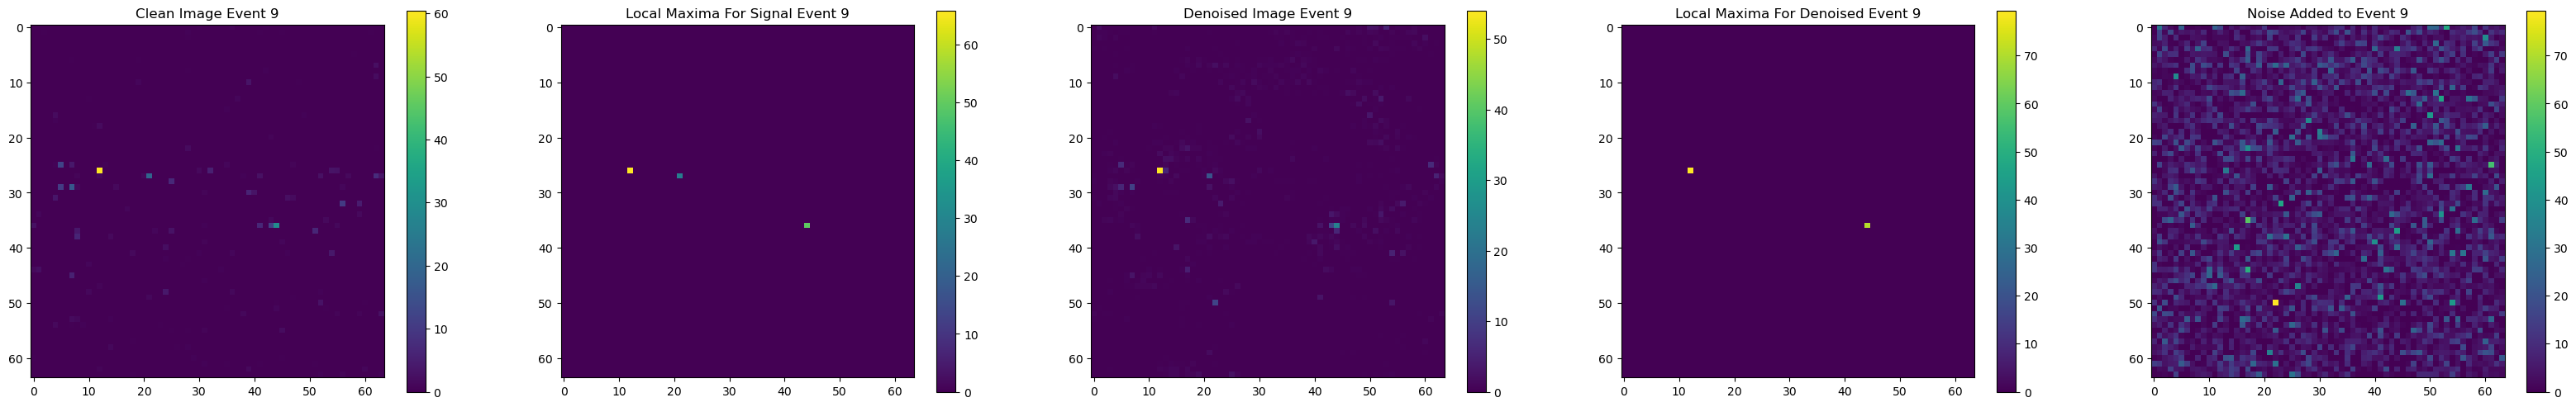

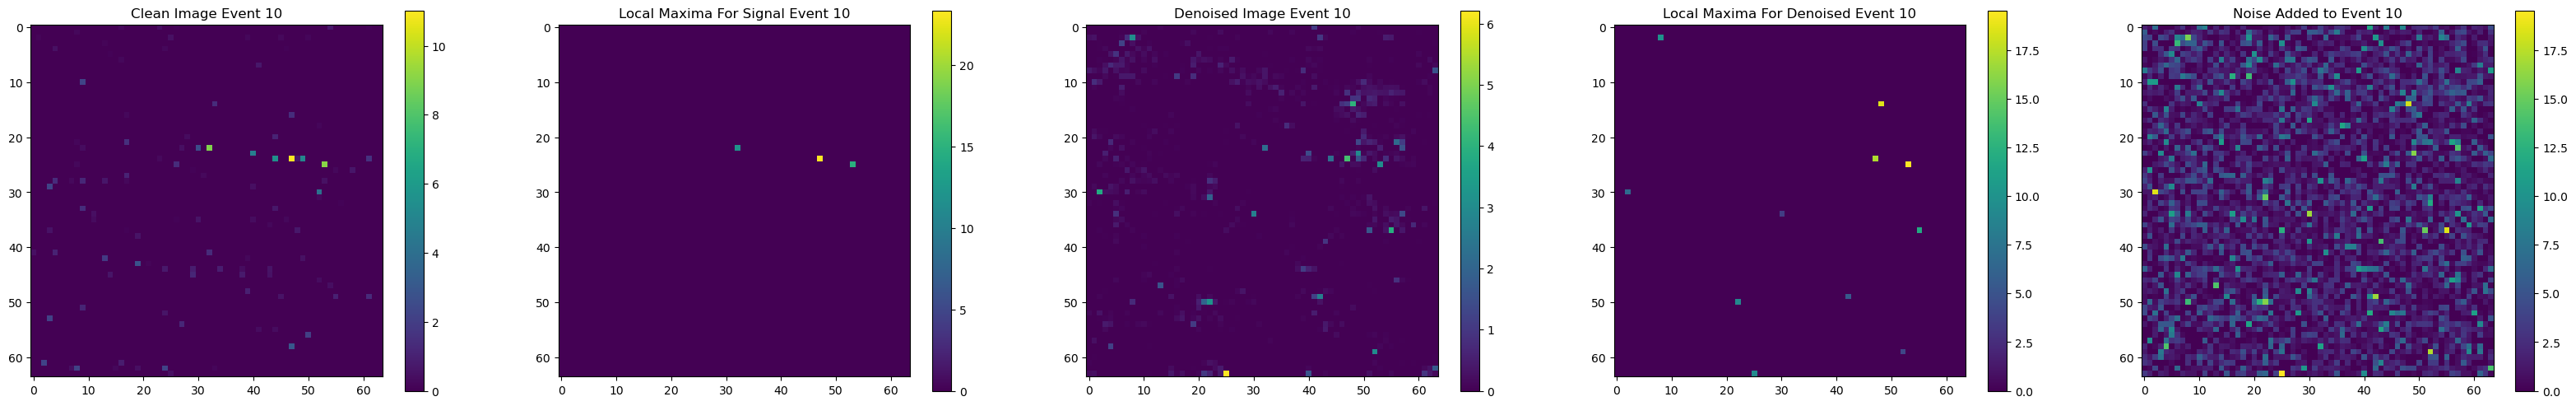

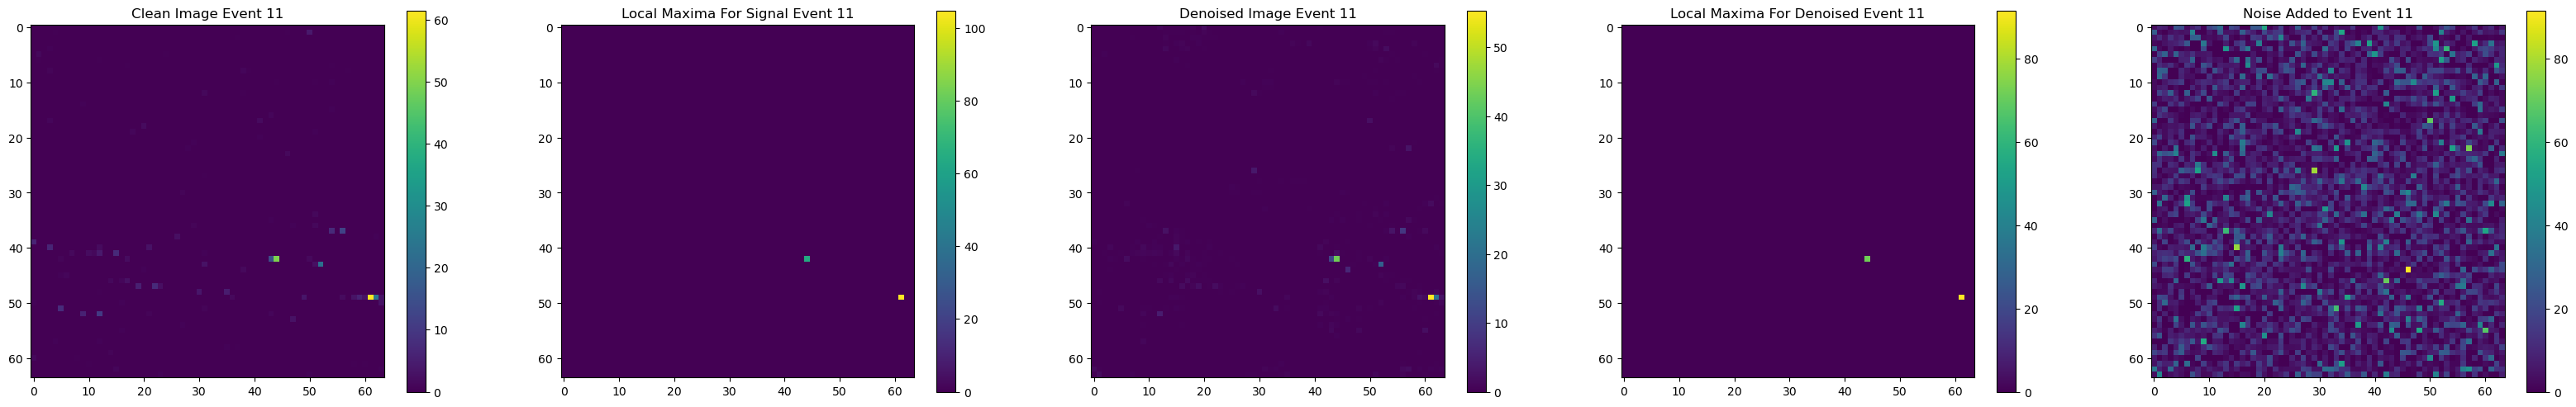

In [22]:
# Assuming clean_frames, model, device, saturation_value, pile_up, modtype, and NoiseScheduler are defined
num_events = end_idx - start_idx
batch_size = 100  # Process all events in a single batch

# Create DataLoader
inference_dataset = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)

timestep = tf.convert_to_tensor(40)

# Pre-allocate lists for differences
jets_clean = []
jets_noisy = []
jets_denoised = []
differences_allJetTypes = []
differences_jets_noisy = []
differences_jets_denoised = []

progress_bar = tqdm(total=num_events//batch_size, desc="Local Maxima Finding")

# Processing batches
for batch_idx, clean_batch in enumerate(inference_dataset):
    random_seed = np.random.randint(0, end_idx - start_idx)

    noisy_images, noise = noise_scheduler.add_noise(
        clean_frame=clean_batch,
        noise_sample=pile_up,
        timestep=timestep,
        random_seed=random_seed,
        n_events=num_events
    )

    # Apply saturation value clipping and scaling
    noisy_images = tf.clip_by_value(noisy_images, 0, saturation_value)

    if modtype == 'UNet2d':
            noise_pred = model([noisy_images, timestep], training=False)[0]
    elif modtype == 'UNet_lite':
            noise_pred = model([noisy_images, timestep], training=False)

    de_noised = tf.nn.relu(noisy_images - noise_pred)

    # Process each image in the batch
    local_maxima_clean, jets_clean = find_local_maxima(clean_batch, 9)
    local_maxima_noisy, jets_noisy = find_local_maxima(noisy_images, 9)
    local_maxima_denoised, jets_denoised = find_local_maxima(de_noised, 9)

    matching_jets_noisy = find_matching_maxima(jets_clean, jets_noisy)
    matching_jets_denoised = find_matching_maxima(jets_clean, jets_denoised)

    differences_jets_noisy.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                                   for ref_maxima, test_maxima_entry in matching_jets_noisy])
    differences_jets_denoised.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                                      for ref_maxima, test_maxima_entry in matching_jets_denoised])
    progress_bar.update(1)
    logs = {"Batch": batch_idx+1}
    progress_bar.set_postfix(**logs)
    # Visualization for debugging, Uncomment if needed
    if batch_idx == 0:        
        for event in range(12):
                fig, axs = plt.subplots(1, 5, figsize=(40, 6))

                im0 = axs[0].imshow(clean_batch[event])
                axs[0].set_title(f"Clean Image Event {event}")
                fig.colorbar(im0, ax=axs[0])

                im1 = axs[1].imshow(local_maxima_clean[event])
                axs[1].set_title(f"Local Maxima For Signal Event {event}")
                fig.colorbar(im1, ax=axs[1])

                im2 = axs[2].imshow(de_noised[event])
                axs[2].set_title(f"Denoised Image Event {event}")
                fig.colorbar(im2, ax=axs[2])

                im3 = axs[3].imshow(local_maxima_denoised[event])
                axs[3].set_title(f"Local Maxima For Denoised Event {event}")
                fig.colorbar(im3, ax=axs[3])

                im4 = axs[4].imshow(noise[event]) # Check noise pattern added different for each event
                axs[4].set_title(f"Noise Added to Event {event}")
                fig.colorbar(im3, ax=axs[4])

                plt.show()

progress_bar.close()

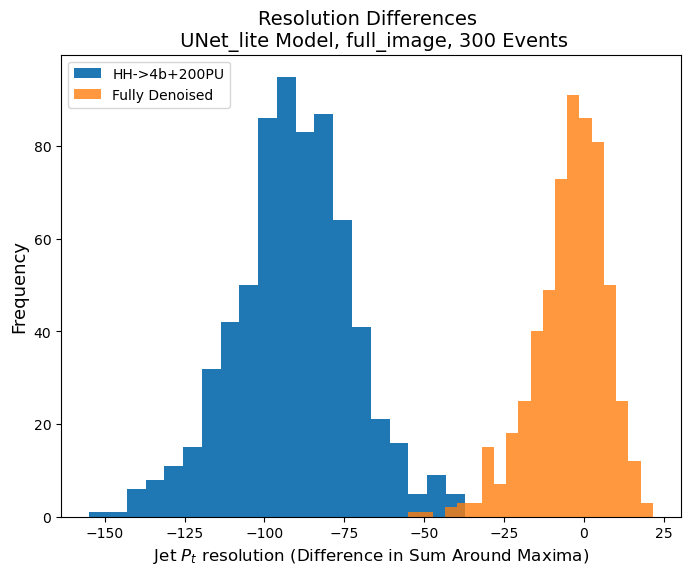

In [23]:
# Plot histograms for each set of differences
plt.figure(figsize=(8, 6))
plt.hist(differences_jets_noisy, bins=20, label='HH->4b+200PU')
plt.hist(differences_jets_denoised, bins=20, alpha=0.8, label='Fully Denoised')
plt.title(f'Resolution Differences \n {modtype} Model, {strip_size}, {num_events} Events', fontsize=14)
plt.xlabel('Jet $P_t$ resolution (Difference in Sum Around Maxima)', fontsize=12)
plt.ylabel('Frequency', fontsize=13)
plt.legend()
plt.show()

In [24]:
print(differences_jets_denoised)

[-8.046562, -6.2308674, -7.2914886, -5.644804, 2.9970684, -6.6234245, 3.36026, -3.6767187, -2.4727173, -20.394844, -7.2573204, -6.5228424, -2.439804, -0.7836609, 1.9535141, 2.9437943, -18.664444, -6.395569, -19.36436, 3.6637497, 5.3852997, 13.37109, 7.124672, -2.155281, -10.398853, -1.4584656, -10.202744, -3.6787987, -2.0148773, -23.081692, 1.3041649, 4.0134583, 10.720131, 1.9792786, -21.243408, -13.282162, 10.389877, 12.462395, -4.848118, 3.9161377, -1.139946, 0.9381714, -12.504944, 14.500713, 7.438629, -1.089531, -9.75103, -14.012367, 21.24818, 0.40220165, -3.0154114, 3.4128494, -8.864334, -12.435226, -8.126211, -4.4734955, -19.552776, 1.4680634, 7.0058975, -16.66391, -1.1492462, 6.1391735, 9.104229, 14.910957, -2.7965393, -4.7165556, -35.345367, -13.477921, -5.9688263, 3.007431, -1.9035835, -3.5866394, -9.940041, 1.5415277, -3.9409485, -12.292633, -31.04898, -19.028137, 21.641294, 6.3135834, -9.769005, -9.951447, -0.32901382, -17.987259, -9.664967, -21.555397, 3.4364853, 6.063629, -

In [25]:

# The jet with the maximum sum_around_maxima is identified as the leading jet for both noisy and denoised images
# Initialize lists to hold the leading jets for each event
leading_jet_noisy = []
leading_jet_denoised = []

# Group the jets by event
jets_noisy_by_event = {}
jets_denoised_by_event = {}

# Populate the dictionaries with lists of jets for each event
for jet in jets_noisy:
    event = jet['event']
    if event not in jets_noisy_by_event:
        jets_noisy_by_event[event] = []
    jets_noisy_by_event[event].append(jet)

for jet in jets_denoised:
    event = jet['event']
    if event not in jets_denoised_by_event:
        jets_denoised_by_event[event] = []
    jets_denoised_by_event[event].append(jet)

# Find the leading jets for noisy images
for event, jets in jets_noisy_by_event.items():
    max_pt_jet = max(jets, key=lambda x: x['sum_around_maxima'])
    leading_jet_noisy.append(max_pt_jet)

# Find the leading jets for denoised images
for event, jets in jets_denoised_by_event.items():
    max_pt_jet = max(jets, key=lambda x: x['sum_around_maxima'])
    leading_jet_denoised.append(max_pt_jet)

# Example print to verify the results
print(leading_jet_noisy[22])
print(leading_jet_denoised[22])


{'event': 44, 'i': 50, 'j': 22, 'pixel_value': 10.035829, 'sum_around_maxima': 137.32585}
{'event': 90, 'i': 1, 'j': 32, 'pixel_value': 9.97681, 'sum_around_maxima': 26.379642}


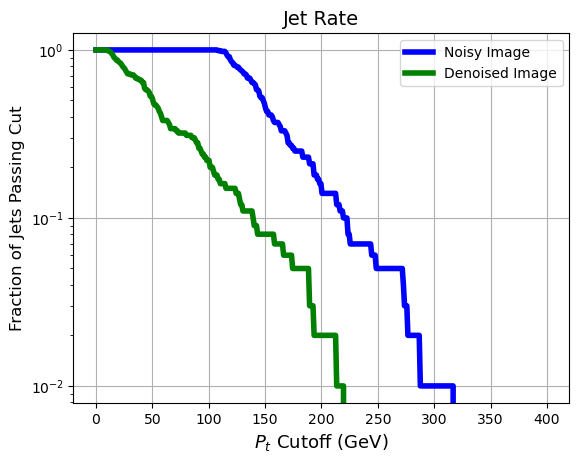

In [26]:
cut_values = np.linspace(0, 400, 400)

pt_values_noisy = [jet['sum_around_maxima'] for jet in leading_jet_noisy]
fraction_passing_noisy = [sum(pt >= cut for pt in pt_values_noisy) / len(pt_values_noisy) for cut in cut_values]

pt_values_denoised = [jet['sum_around_maxima'] for jet in leading_jet_denoised]
fraction_passing_denoised = [sum(pt >= cut for pt in pt_values_denoised) / len(pt_values_denoised) for cut in cut_values]

plt.plot(cut_values, fraction_passing_noisy, linewidth = 4, color='b', label='Noisy Image')
plt.plot(cut_values, fraction_passing_denoised, linewidth = 4, color='g', label='Denoised Image')
plt.title('Jet Rate', fontsize = 14)
plt.xlabel('$P_t$ Cutoff (GeV)', fontsize = 13)
plt.ylabel('Fraction of Jets Passing Cut', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()